# 1. Chia tập train test

- Đảm bảo tỷ lệ giữa label 1 và 0 vẫn giữ nguyên sau khi chia

In [1]:
"""
Chia dataset sau augmentation thành train/test
- Stratified theo label
- Group-aware (nếu có original_id)
- Tỷ lệ tùy chỉnh
"""

import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import os

# ==============================
# 1. CONFIG
# ==============================
INPUT_CSV = '/kaggle/input/cross-site-scripting-xss-dataset-for-deep-learning/XSS_dataset.csv' 
TEXT_COL = "text"
LABEL_COL = "label"
ID_COL = "original_id"                 
TRAIN_RATIO = 0.8
OUTPUT_DIR = "split_dataset"
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==============================
# 2. LOAD DATA
# ==============================
print(f"Loading augmented dataset: {INPUT_CSV}")
df = pd.read_csv(INPUT_CSV)
df = df.rename(columns={'Sentence': 'text', 'Label': 'label'})
required_cols = [TEXT_COL, LABEL_COL]
if ID_COL and ID_COL not in df.columns:
    print(f"Warning: {ID_COL} không tồn tại → dùng split đơn giản")
    ID_COL = None
else:
    required_cols.append(ID_COL)

missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise ValueError(f"Thiếu cột: {missing}")

df = df[required_cols].copy()
df[TEXT_COL] = df[TEXT_COL].astype(str)
df[LABEL_COL] = df[LABEL_COL].astype(int)

print(f"Total: {len(df)} | XSS (1): {df[LABEL_COL].sum()} | Safe (0): {len(df)-df[LABEL_COL].sum()}")
print(f"Label ratio: {df[LABEL_COL].mean():.4f}")

# ==============================
# 3. STRATIFIED SPLIT (Group-aware nếu có ID)
# ==============================
y = df[LABEL_COL]

if ID_COL:
    print(f"Using GroupShuffleSplit với {ID_COL} để tránh leakage...")
    groups = df[ID_COL]
    gss = GroupShuffleSplit(n_splits=1, train_size=TRAIN_RATIO, random_state=SEED)
    train_idx, test_idx = next(gss.split(df, y, groups))
else:
    print("No ID column → dùng train_test_split (stratified)")
    train_idx, test_idx = train_test_split(
        range(len(df)), 
        train_size=TRAIN_RATIO, 
        stratify=y, 
        random_state=SEED
    )

train_df = df.iloc[train_idx].copy()
test_df = df.iloc[test_idx].copy()

# ==============================
# 4. KIỂM TRA PHÂN BỐ NHÃN
# ==============================
def print_distribution(df, name):
    ratio = df[LABEL_COL].mean()
    print(f"{name:5}: {len(df):6} samples | XSS: {df[LABEL_COL].sum():5} | Safe: {len(df)-df[LABEL_COL].sum():5} | Ratio: {ratio:.4f}")

print("\n" + "="*70)
print("SPLIT RESULTS")
print("="*70)
print_distribution(train_df, "TRAIN")
print_distribution(test_df,  "TEST ")

# Kiểm tra sự khác biệt nhỏ
diff = abs(train_df[LABEL_COL].mean() - test_df[LABEL_COL].mean())
print(f"\nLabel ratio difference: {diff:.6f} → ", end="")
if diff < 0.005:
    print("RẤT TỐT (gần giống hoàn toàn)")
else:
    print("Cảnh báo: Chênh lệch lớn → kiểm tra dữ liệu")

# ==============================
# 5. LƯU FILE
# ==============================
train_path = os.path.join(OUTPUT_DIR, "train.csv")
test_path = os.path.join(OUTPUT_DIR, "test.csv")

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"\nSaved:")
print(f"  → {train_path}")
print(f"  → {test_path}")

# ==============================
# 6. THỐNG KÊ CHI TIẾT (optional)
# ==============================
if ID_COL:
    train_ids = set(train_df[ID_COL])
    test_ids = set(test_df[ID_COL])
    overlap = train_ids.intersection(test_ids)
    print(f"\nGroup leakage check: {len(overlap)} IDs xuất hiện ở cả train và test → ", end="")
    print("OK" if len(overlap) == 0 else "CÓ LEAKAGE!")

print(f"\nDone! Dataset sẵn sàng để train LLM.")

Loading augmented dataset: /kaggle/input/cross-site-scripting-xss-dataset-for-deep-learning/XSS_dataset.csv
Total: 13686 | XSS (1): 7373 | Safe (0): 6313
Label ratio: 0.5387
No ID column → dùng train_test_split (stratified)

SPLIT RESULTS
TRAIN:  10948 samples | XSS:  5898 | Safe:  5050 | Ratio: 0.5387
TEST :   2738 samples | XSS:  1475 | Safe:  1263 | Ratio: 0.5387

Label ratio difference: 0.000014 → RẤT TỐT (gần giống hoàn toàn)

Saved:
  → split_dataset/train.csv
  → split_dataset/test.csv

Done! Dataset sẵn sàng để train LLM.


# 2. Phát hiện ngữ cảnh của payload trong data set ban đầu (Sử dụng heuristic_label gán nhãn 1 phần và Logictic regression để gán nhãn còn lại )

In [2]:
"""
pipeline_context_detection.py

Yêu cầu:
pip install scikit-learn pandas joblib

Cách dùng:
- Đưa file CSV có ít nhất 1 cột 'payload'. Tuỳ chọn: cột 'original_id' để tránh leakage khi split.
- Chạy script, kết quả: model (joblib), vectorizer (joblib), csv output có cột predicted_context & confidence.
"""

import re
import html
import urllib.parse
import unicodedata
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.model_selection import GroupShuffleSplit
RANDOM_STATE = 42

# --- 1) Canonicalize helper ---
def canonicalize(payload: str) -> str:
    """Giải mã percent-encoding, HTML entities, unicode normalize"""
    if not isinstance(payload, str):
        return ""
    try:
        s = urllib.parse.unquote(payload)           # percent-decoding
        s = html.unescape(s)                        # html entities
        s = unicodedata.normalize('NFC', s)         # unicode normalization
        return s
    except Exception:
        return payload

# --- 2) Heuristic labeller ---
import re

def heuristic_label(payload: str) -> str:
    if not isinstance(payload, str) or not payload.strip():
        return "unknown"

    p = payload.strip()
    lower = p.lower()

    # 1. HTML TAGS (ưu tiên cao nhất)
    if re.search(r"<[a-zA-Z][^>]*>", lower):
        if re.search(r"\bon\w+\s*=", lower):
            return "html_attribute"
        if re.search(r"<script\b", lower) or re.search(r"<style\b", lower):
            return "html_body"
        return "html_body"

    # 2. JAVASCRIPT PROTOCOL
    if re.search(r"\bjavascript\s*:", lower):
        return "js_string"

    # 3. JS ESCAPES
    if re.search(r"\\u[0-9a-fA-F]{4}|\\x[0-9a-fA-F]{2}|\\([0-7]{1,3})", p):
        return "js_string"

    # 4. JS KEYWORDS
    if re.search(r"\b(alert|eval|document\.|window\.|location\.|cookie)\b", lower):
        return "js_string"

    # 5. CSS
    if re.search(r"\bexpression\s*\(|url\s*\([^)]*javascript:|@import", lower):
        return "css"

    # 6. URL
    if re.search(r"^https?://|\?|&|=|%[0-9a-fA-F]{2}", p):
        return "url"

    return "unknown"

# --- 3) Load dataset (example) ---
def load_payloads(csv_path: str, payload_col: str = "payload", id_col: str = None) -> pd.DataFrame:
    df = pd.read_csv(csv_path, dtype=str).fillna("")
    if payload_col not in df.columns:
        raise ValueError(f"CSV không có cột '{payload_col}'")
    if id_col and id_col not in df.columns:
        raise ValueError(f"CSV không có cột id '{id_col}'")
    # canonicalize once
    df['payload_canon'] = df[payload_col].apply(canonicalize)
    if id_col:
        df['original_id'] = df[id_col]
    else:
        df['original_id'] = df.index.astype(str)
    return df

# --- 4) Apply heuristic to get weak labels ---
def apply_heuristic(df: pd.DataFrame, payload_col: str = 'payload_canon') -> pd.DataFrame:
    df = df.copy()
    df['heuristic_label'] = df[payload_col].apply(heuristic_label)
    # mark those with 'unknown' as unlabeled
    df['is_labeled'] = df['heuristic_label'].apply(lambda x: x != 'unknown')
    return df

# --- 5) Train classifier on heuristic-labeled subset ---
def train_classifier_from_heuristic(df: pd.DataFrame, payload_col='payload_canon',
                                    label_col='heuristic_label', model_out_path='context_clf.joblib',
                                    vect_out_path='vectorizer.joblib'):
    train_df = df[df['is_labeled']].copy()
    X = train_df[payload_col].values
    y = train_df[label_col].values
    groups = train_df['original_id'].values if 'original_id' in train_df.columns else None

    vect = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=20000)
    Xv = vect.fit_transform(X)

    if groups is not None and len(np.unique(groups)) > 5:
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
        train_idx, test_idx = next(splitter.split(Xv, y, groups))
        Xtr, Xte = Xv[train_idx], Xv[test_idx]
        ytr, yte = np.array(y)[train_idx], np.array(y)[test_idx]
    else:
        Xtr, Xte, ytr, yte = train_test_split(Xv, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

    clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
    clf.fit(Xtr, ytr)

    print(classification_report(yte, clf.predict(Xte)))
    clf.fit(Xv, y)  # final fit
    return clf, vect

# --- 6) Predict remaining unlabeled with confidence ---
def predict_and_propagate(df: pd.DataFrame, clf, vect, payload_col='payload_canon',
                          out_conf_col='pred_confidence', out_label_col='predicted_context',
                          threshold=0.6):
    df = df.copy()
    Xall = df[payload_col].values
    Xv_all = vect.transform(Xall)
    probs = clf.predict_proba(Xv_all)
    classes = clf.classes_
    idx_max = probs.argmax(axis=1)
    confs = probs[np.arange(len(probs)), idx_max]
    preds = classes[idx_max]

    df[out_label_col] = preds
    df[out_conf_col] = confs

    # nếu heuristic labeled rồi thì ta giữ heuristic_label thay vì model? Tùy ý.
    # Ở đây ta lưu cả 2 để so sánh: final_label = heuristic_label if is_labeled else model_pred (với threshold)
    df['final_label'] = df.apply(
        lambda r: r['heuristic_label'] if r.get('is_labeled', False) else (r[out_label_col] if r[out_conf_col] >= threshold else 'unknown'),
        axis=1
    )
    return df
class Args:
    input = "/kaggle/working/split_dataset/train.csv"
    payload_col = "text"      # nếu file của bạn có cột tên "Sentence"
    id_col = None
    model_out = "/kaggle/working/context_clf.joblib"
    vect_out = "/kaggle/working/vectorizer.joblib"
    out_csv = "/kaggle/working/payload_with_context.csv"
    threshold = 0.6


# --- 7) Example run (script section) ---
if __name__ == "__main__":
    args = Args()
    print("Loading dataset...")
    df = load_payloads(args.input, payload_col=args.payload_col, id_col=args.id_col)
    print(f"Loaded {len(df)} rows.")

    print("Applying heuristic labeling...")
    df = apply_heuristic(df)

    n_labeled = df['is_labeled'].sum()
    print(f"Heuristic gán nhãn cho {n_labeled} rows (trong {len(df)})")

    if n_labeled < 50:
        print("Cảnh báo: quá ít heuristic-labeled samples. Hãy thêm dữ liệu nhãn tay hoặc relax heuristic.")
    else:
        print("Training classifier on heuristic-labeled subset...")
        clf, vect = train_classifier_from_heuristic(df, payload_col='payload_canon',
                                                    label_col='heuristic_label',
                                                    model_out_path=args.model_out,
                                                    vect_out_path=args.vect_out)

        print("Predicting on full dataset and propagating labels...")
        df_out = predict_and_propagate(df, clf, vect, payload_col='payload_canon', threshold=args.threshold)

        # save results
        df_out.to_csv(args.out_csv, index=False)
        print(f"Saved augmented dataset to {args.out_csv}")


Loading dataset...
Loaded 10948 rows.
Applying heuristic labeling...
Heuristic gán nhãn cho 9619 rows (trong 10948)
Training classifier on heuristic-labeled subset...
                precision    recall  f1-score   support

html_attribute       1.00      1.00      1.00      1128
     html_body       0.99      0.98      0.99       784
     js_string       0.37      0.78      0.50         9
           url       0.00      0.00      0.00         3

      accuracy                           0.99      1924
     macro avg       0.59      0.69      0.62      1924
  weighted avg       0.99      0.99      0.99      1924

Predicting on full dataset and propagating labels...
Saved augmented dataset to /kaggle/working/payload_with_context.csv


## Phân bố nhãn Context sau khi gán

/tmp/ipykernel_13/2366232635.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


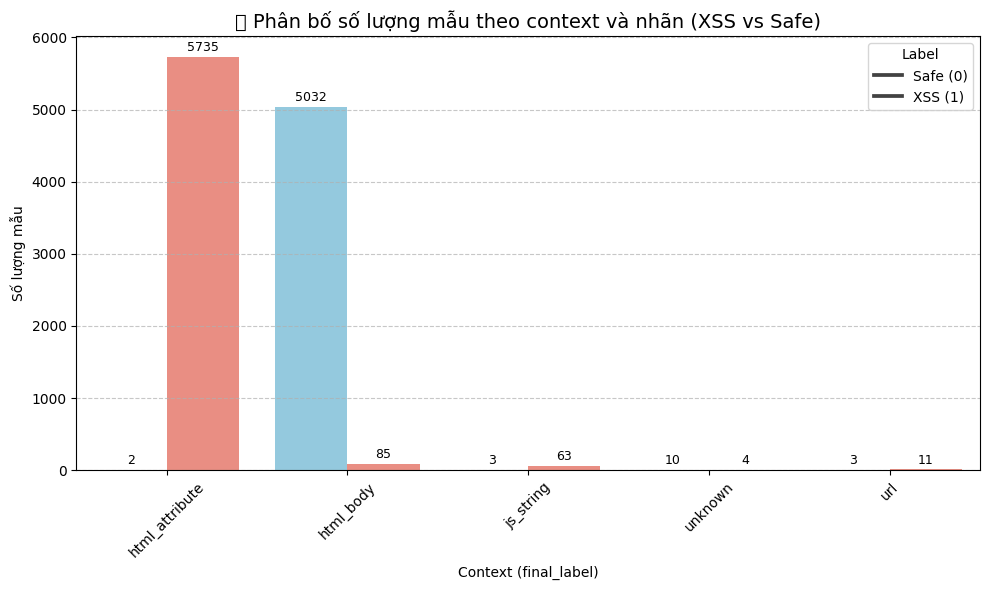

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Đảm bảo kiểu dữ liệu đúng
df_out['label'] = df_out['label'].astype(int)
df_out['final_label'] = df_out['final_label'].astype(str)

# Đếm số lượng mẫu theo context và nhãn
count_df = df_out.groupby(['final_label', 'label']).size().reset_index(name='count')

# Thiết lập kích thước & style
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=count_df,
    x='final_label',
    y='count',
    hue='label',
    palette={0: 'skyblue', 1: 'salmon'}
)

# Tiêu đề và nhãn
plt.title("📊 Phân bố số lượng mẫu theo context và nhãn (XSS vs Safe)", fontsize=14)
plt.xlabel("Context (final_label)")
plt.ylabel("Số lượng mẫu")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Label', labels=['Safe (0)', 'XSS (1)'])
plt.tight_layout()

# 💬 Hiển thị số lượng cụ thể trên cột
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

plt.show()


# 3. Thực hiện tăng cường dữ liệu


**Logic Mô Tả Ngắn Gọn về OWASPXSSAugmenterClass này hoạt động như một công cụ sinh ra các biến thể của các chuỗi đầu vào (payload XSS hoặc mẫu an toàn), giúp làm cho các mô hình bảo mật mạnh mẽ hơn bằng cách tiếp xúc với nhiều dạng tấn công thực tế hơn, đặc biệt là các dạng bị làm rối (obfuscated).**


In [4]:
agument_df = df_out[['text', 'label', 'original_id', 'final_label']].copy()

Khởi Tạo và Danh Sách Kỹ Thuật
Phương thức __init__ khởi tạo hạt giống ngẫu nhiên (random.seed) để đảm bảo tính tái lập (reproducibility) và gọi _init_bypass_techniques.

Phương thức _init_bypass_techniques tạo ra các danh sách cố định chứa các thành phần thường dùng trong tấn công XSS hoặc kỹ thuật lẩn tránh, bao gồm:

* event_handlers: Các thuộc tính sự kiện HTML (ví dụ: onerror, onload).

* xss_tags: Các thẻ HTML nguy hiểm hoặc có thể dùng trong XSS (ví dụ: script, img, svg).

* protocols: Các giao thức nguy hiểm (ví dụ: javascript:, data:).

* case_patterns: Các hàm thay đổi chữ hoa/thường (ví dụ: TO UPPER, To LowER).

* null_bytes và special_chars: Các ký tự đặc biệt hoặc byte null dùng để phá vỡ parser hoặc regex.

Các Hàm Encoding và Obfuscation (Làm Rối)
Đây là trái tim của việc tăng cường dữ liệu XSS. Mỗi hàm áp dụng một kỹ thuật lẩn tránh cụ thể:

* _html_entity_encode, _decimal_encode: Mã hóa chuỗi thành các thực thể HTML (thập lục phân &#x...; hoặc thập phân &#...;) để lẩn tránh bộ lọc.

* _url_encode: Mã hóa URL (ví dụ: %20, %3c).

* _unicode_encode, _hex_encode, _octal_encode: Mã hóa các ký tự thành các định dạng mã hóa khác nhau (ví dụ: \uXXXX, \xXX, \OOO) thường dùng trong ngữ cảnh JavaScript hoặc CSS.

* _add_null_bytes, _add_whitespace: Chèn các ký tự null hoặc khoảng trắng vào thẻ/payload để đánh lừa các bộ lọc chỉ kiểm tra ở đầu chuỗi.

* _case_variation: Thay đổi chữ hoa/thường ngẫu nhiên của các từ khóa (ví dụ: sCrIpT thay vì script).

* _comment_obfuscation: Chèn comment HTML vào giữa thẻ/payload (ví dụ: <script>).

* _attribute_quotes_variation: Thay đổi kiểu dấu ngoặc kép thuộc tính (dấu nháy đơn, dấu huyền, hoặc không có).

* _protocol_variation, _event_handler_variation, _tag_variation: Thay thế các từ khóa nguy hiểm bằng các biến thể hoặc từ khóa thay thế tương đương.

**Logic Tăng Cường Chính (augment_xss_sample & augment_safe_sample)**
1. augment_xss_sample (Cho payload XSS, label=1):

* Nó gọi _advanced_bypass_by_context để tạo ra các biến thể.

* Các kỹ thuật lẩn tránh được áp dụng có điều kiện dựa trên ngữ cảnh (context) của payload (ví dụ: html_body, html_attribute, js_string, css, url). Việc này bắt chước cách các cuộc tấn công thực tế được điều chỉnh để vượt qua các bộ lọc cụ thể của từng ngữ cảnh.

*  Mỗi ngữ cảnh áp dụng một bộ kỹ thuật obfuscation và encoding khác nhau (ví dụ: ngữ cảnh js_string ưu tiên mã hóa Unicode, Hex; ngữ cảnh html_body ưu tiên thay đổi chữ hoa/thường và chèn khoảng trắng).

2. augment_safe_sample (Cho mẫu an toàn, label=0):

Nó không thực hiện bất kỳ encoding hay obfuscation nào.

 Chỉ đơn giản là đặt mẫu an toàn vào các template ngữ cảnh an toàn có sẵn > (ví dụ: > <p>...</p>, <input value='...'>, console.log('...'))>  để dạy mô hình rằng việc đặt dữ liệu vào các thẻ/thuộc tính HTML an toàn sau khi được mã hóa (bởi hàm html.escape) vẫn là an toàn.[Cheat sheet](http://cheatsheetseries.owasp.org/cheatsheets/XSS_Filter_Evasion_Cheat_Sheet.html)

In [5]:
import re
import random
import html
from typing import List
import pandas as pd
from tqdm.auto import tqdm


class OWASPXSSAugmenter:
    """
    Tăng cường dữ liệu XSS dựa trên OWASP XSS Cheat Sheet
    """

    def __init__(self, seed: int = 42):
        random.seed(seed)
        self._init_bypass_techniques()

    # --------------------------------------------------------------------- #
    #  Khởi tạo các danh sách kỹ thuật
    # --------------------------------------------------------------------- #
    def _init_bypass_techniques(self):
        self.event_handlers = [
            'onerror', 'onload', 'onclick', 'onmouseover', 'onmouseout',
            'onfocus', 'onblur', 'onchange', 'onsubmit', 'onreset',
            'onselect', 'onkeydown', 'onkeyup', 'onkeypress',
            'ondblclick', 'onmousedown', 'onmouseup', 'onmousemove',
            'oncontextmenu', 'ondrag', 'ondrop', 'oninput',
            'onanimationstart', 'onanimationend', 'ontransitionend',
            'onloadstart', 'onprogress', 'onabort', 'onloadend',
            'onwheel', 'onscroll', 'oncopy', 'oncut', 'onpaste',
            'onsearch', 'ontoggle', 'onshow', 'onpointerover',
            'onpointerenter', 'onpointerdown', 'onpointermove',
            'onresize', 'onhashchange', 'onstorage', 'onmessage',
            'onoffline', 'ononline', 'onbeforeunload', 'onunload',
            'onbeforeprint', 'onafterprint', 'onpagehide', 'onpageshow',
            'onpopstate', 'onfocusin', 'onfocusout', 'oninvalid',
            'onreadystatechange', 'ontimeupdate', 'onvolumechange',
            'onratechange', 'onseeked', 'onseeking', 'onstalled',
            'onsuspend', 'onplay', 'onplaying', 'onpause', 'onended',
            'onwaiting', 'oncanplay', 'oncanplaythrough', 'onemptied'
        ]

        self.xss_tags = [
            'script', 'img', 'svg', 'iframe', 'body', 'input',
            'select', 'textarea', 'button', 'form', 'object',
            'embed', 'applet', 'link', 'meta', 'base', 'style',
            'video', 'audio', 'source', 'track', 'canvas',
            'details', 'summary', 'marquee', 'bgsound', 'keygen',
            'a', 'isindex', 'frame', 'frameset', 'table', 'td',
            'div'
        ]

        self.protocols = [
            'javascript:', 'data:', 'vbscript:', 'file:',
            'about:', 'ms-its:', 'mhtml:', 'jar:'
        ]

        self.case_patterns = [
            lambda s: s.upper(),
            lambda s: s.lower(),
            lambda s: ''.join(c.upper() if i % 2 == 0 else c.lower()
                              for i, c in enumerate(s)),
            lambda s: ''.join(c.upper() if random.random() > 0.5 else c.lower()
                              for c in s),
        ]

        self.null_bytes = ['\\x00', '%00', '&#0;', '&#x0;']
        self.special_chars = ['\\t', '\\n', '\\r', '\\f', '\\v', ' ']

    # --------------------------------------------------------------------- #
    #  Encoding helpers (đảm bảo không sinh ra \u escape lỗi)
    # --------------------------------------------------------------------- #
    def _html_entity_encode(self, text: str, full: bool = False) -> str:
        def enc(c):
            if c in '<>/':
                return c
            return f'&#x{ord(c):x};' if random.random() > 0.7 else c
        return ''.join(enc(c) for c in text) if not full else \
               ''.join(f'&#x{ord(c):x};' if c not in '<>/' else c for c in text)

    def _decimal_encode(self, text: str, full: bool = False, semicolon: bool = True) -> str:
        sep = ';' if semicolon else ''
        def enc(c):
            if c in '<>/':
                return c
            return f'&#{ord(c)}{sep}' if random.random() > 0.7 else c
        return ''.join(enc(c) for c in text) if not full else \
               ''.join(f'&#{ord(c)}{sep}' if c not in '<>/' else c for c in text)

    def _url_encode(self, text: str, full: bool = False) -> str:
        safe = '<>/'
        if full:
            return ''.join(f'%{ord(c):02x}' for c in text)
        return ''.join(f'%{ord(c):02x}' if c not in safe and random.random() > 0.8 else c
                       for c in text)

    def _unicode_encode(self, text: str) -> str:
        """Trả về \\uXXXX (raw string)"""
        return ''.join(
            f'\\\\u{ord(c):04x}' if c.isalpha() and random.random() > 0.7 else c
            for c in text
        )

    def _hex_encode(self, text: str) -> str:
        return ''.join(f'\\\\x{ord(c):02x}' for c in text)

    def _octal_encode(self, text: str) -> str:
        return ''.join(f'\\\\{ord(c):03o}' for c in text)

    # --------------------------------------------------------------------- #
    #  Bypass helpers
    # --------------------------------------------------------------------- #
    def _add_null_bytes(self, text: str) -> str:
        if '<' in text:
            null = random.choice(self.null_bytes)
            # replace tối đa 2 lần để tránh over-obfuscate
            for _ in range(random.randint(1, 2)):
                text = text.replace('<', f'<{null}', 1)
        return text

    def _add_whitespace(self, text: str) -> str:
        if '<' in text and '>' in text:
            ws = random.choice(self.special_chars)
            text = re.sub(r'(<\w+)', rf'\1{ws * random.randint(1, 3)}', text)
        return text

    def _case_variation(self, text: str) -> str:
        if any(tag in text.lower() for tag in self.xss_tags):
            pat = random.choice(self.case_patterns)
            for tag in self.xss_tags:
                if tag in text.lower():
                    regex = re.compile(re.escape(tag), re.IGNORECASE)
                    text = regex.sub(pat(tag), text)
        return text

    def _comment_obfuscation(self, text: str) -> str:
        if '<' in text:
            comment = random.choice(['<!--x-->', '<!---->', '<!-- -->'])
            positions = ['<script>', '<img', '<svg', 'javascript:']
            for pos in positions:
                if pos.lower() in text.lower():
                    text = re.sub(re.escape(pos), f'{pos}{comment}',
                                  text, flags=re.IGNORECASE)
        return text

    def _attribute_quotes_variation(self, text: str) -> str:
        r = random.random()
        if r > 0.66:
            text = text.replace('"', '').replace("'", '')
        elif r > 0.33:
            text = text.replace('"', "'")
        else:
            text = text.replace('"', '`').replace("'", '`')
        return text

    def _protocol_variation(self, text: str) -> str:
        if 'javascript:' in text.lower():
            vars_ = [
                'javascript:', 'javascript&#58;', 'java\\nscript:',
                'java\\tscript:', 'jAvAsCrIpT:', '&#106;avascript:',
                'j&#97;vascript:', 'jav&#x61;script:'
            ]
            text = re.sub(r'javascript:', random.choice(vars_), text,
                          flags=re.IGNORECASE)
        return text

    def _event_handler_variation(self, text: str) -> str:
        for ev in self.event_handlers:
            if ev in text.lower():
                if random.random() < 0.5:
                    pat = random.choice(self.case_patterns)
                    text = re.sub(re.escape(ev), pat(ev), text,
                                  flags=re.IGNORECASE)
                else:
                    alt = random.choice(self.event_handlers)
                    text = re.sub(re.escape(ev), alt, text,
                                  flags=re.IGNORECASE)
        return text

    def _tag_variation(self, text: str) -> str:
        alt_map = {
            'script': ['svg', 'iframe', 'object', 'embed', 'video', 'audio'],
            'img': ['svg', 'video', 'audio', 'iframe', 'input'],
            'body': ['div', 'table'],
        }
        for orig, alts in alt_map.items():
            if orig in text.lower() and random.random() > 0.3:
                new = random.choice(alts)
                text = re.sub(re.escape(f'<{orig}'), f'<{new}', text,
                              flags=re.IGNORECASE)
                text = re.sub(re.escape(f'</{orig}>'), f'</{new}>', text,
                              flags=re.IGNORECASE)
        return text

    def _encoding_bypass(self, text: str, context: str) -> str:
        if '<' not in text or '>' not in text:
            return text

        choices = ['html_entity', 'decimal', 'unicode', 'mixed']
        if context in ('url', 'css', 'js_string'):
            choices.append('url')
        typ = random.choice(choices)

        if typ == 'html_entity':
            text = self._html_entity_encode(text, full=random.random() > 0.5)
        elif typ == 'decimal':
            text = self._decimal_encode(text,
                                        full=random.random() > 0.5,
                                        semicolon=random.random() > 0.5)
        elif typ == 'url':
            text = self._url_encode(text, full=context == 'url')
        elif typ == 'unicode':
            for kw in ('script', 'alert', 'onerror', 'onload'):
                if kw in text.lower():
                    enc = self._unicode_encode(kw)
                    text = re.sub(re.escape(kw), enc, text,
                                  flags=re.IGNORECASE)
        elif typ == 'mixed':
            text = self._html_entity_encode(text, full=False)
            text = self._url_encode(text, full=False)
        return text

    # --------------------------------------------------------------------- #
    #  Augmentation core
    # --------------------------------------------------------------------- #
    def augment_xss_sample(self, text: str, context: str,
                           n_variations: int = 5) -> List[str]:
        all_vars = self._advanced_bypass_by_context(text, context)
        if len(all_vars) <= n_variations:
            return all_vars
        return [text] + random.sample(
            [v for v in all_vars if v != text],
            min(n_variations - 1, len(all_vars) - 1)
        )

    def _advanced_bypass_by_context(self, text: str, context: str) -> List[str]:
        vars_ = [text]

        if context == "html_body":
            v = self._case_variation(text)
            v = self._add_whitespace(v)
            v = self._add_null_bytes(v)
            v = self._comment_obfuscation(v)
            v = self._encoding_bypass(v, context)
            vars_.extend([v, self._tag_variation(text), self._add_null_bytes(text)])

        elif context == "html_attribute":
            vars_.extend([
                self._attribute_quotes_variation(text),
                self._event_handler_variation(text),
                self._protocol_variation(text),
                self._encoding_bypass(text, context),
                self._add_null_bytes(text)
            ])

        elif context == "js_string":
            vars_.extend([
                self._unicode_encode(text),
                self._hex_encode(text),
                self._octal_encode(text),
                self._comment_obfuscation(text),
                self._case_variation(text),
                self._encoding_bypass(text, context)
            ])

        elif context == "css":
            vars_.extend([
                self._url_encode(text),
                self._unicode_encode(text),
                self._comment_obfuscation(text),
                self._encoding_bypass(text, context)
            ])

        elif context == "url":
            vars_.extend([
                self._url_encode(text),
                self._protocol_variation(text),
                self._case_variation(text),
                self._encoding_bypass(text, context)
            ])

        # Loại bỏ trùng lặp & rỗng
        return list({v for v in vars_ if v.strip()})

    def augment_safe_sample(self, text: str, n_variations: int = 3, context: str = None) -> List[str]:
        """
        Sinh biến thể cho mẫu an toàn (label=0) mà KHÔNG thực hiện bất kỳ encoding/obfuscation nào.
        Trả về tối đa n_variations biến thể (bao gồm text gốc).
        """
        vars_ = [text]
    
        # Templates chọn lọc -> bao phủ nhiều ngữ cảnh "safe" mà không tạo payload thực thụ
        safe_templates = [
            f"<p>{html.escape(text)}</p>",
            f"<div class='comment'>{html.escape(text)}</div>",
            f"<!-- User comment --> {html.escape(text)}",
            f"<input value='{html.escape(text)}'>",
            f"<a href='/?q={html.escape(text)}'>{html.escape(text)}</a>",
            f"console.log('{text}');",
            f"// {text}",
            f"/* {text} */",
            f"function showMessage(){{ alert('{text}'); }}  // benign example",
            f"<script>var safeText = '{text}';</script>",
            f"data-user-input='{html.escape(text)}'",
            f"Search results for: {html.escape(text)}",
        ]
    
        # Nếu có context cụ thể, ưu tiên templates phù hợp (tuỳ chọn)
        if context and 'attribute' in context:
            templates = [t for t in safe_templates if any(k in t for k in ["input", "data-user-input", "value", "href"])]
            if templates:
                safe_templates = templates + safe_templates
        elif context and (context == 'url'):
            # ưu tiên các templates có url
            safe_templates = [t for t in safe_templates if 'href' in t or '/?q=' in t] + safe_templates
    
        # Chọn ngẫu nhiên một vài biến thể (không quá nhiều)
        k = min(max(0, n_variations - 1), len(safe_templates))
        if k > 0:
            vars_.extend(random.sample(safe_templates, k))
    
        # Không thực hiện bất kỳ encoding nào cho safe samples.
        # Loại trùng lặp nhưng giữ thứ tự xuất hiện:
        result = list(dict.fromkeys([v for v in vars_ if v and str(v).strip()]))
    
        return result

    # --------------------------------------------------------------------- #
    #  Public API
    # --------------------------------------------------------------------- #
    def augment_dataset(
        self,
        df: pd.DataFrame,
        n_xss_variations: int = 5,
        n_safe_variations: int = 2
    ) -> pd.DataFrame:
  
        print("\n" + "="*70)
        print("ADVANCED XSS DATA AUGMENTATION (OWASP-BASED)")
        print("="*70)

        rows = []
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Augmenting"):
            sentence = row['text']
            label    = row['label']
            ctx      = row['final_label']

            if label == 1:
                vars_ = self.augment_xss_sample(sentence, ctx, n_xss_variations)
            else:
                vars_ = self.augment_safe_sample(sentence, n_safe_variations, ctx)

            for v in vars_:
                rows.append({'text': v, 'label': label})

        aug_df = pd.DataFrame(rows)
        aug_df['label'] = aug_df['label'].astype(int)
        # ---- stats ----
        print("\n" + "="*70)
        print("AUGMENTATION STATISTICS")
        print("="*70)
        print(f"Original size : {len(df)}")
        print(f"Augmented size: {len(aug_df)}")
        print(f"Factor        : {len(aug_df)/len(df):.2f}x")
        print(f"XSS samples   : {(aug_df['label']==1).sum()}")
        print(f"Safe samples  : {(aug_df['label']==0).sum()}")
        print(f"Ratio XSS/Safe: {(aug_df['label']==1).sum()/(aug_df['label']==0).sum():.2f}")
        print("="*70)

        return aug_df

In [6]:
# =====================================
# 1. TẠO INSTANCE AUGMENTER
# =====================================
Agumentor = OWASPXSSAugmenter()

# =====================================
# 2. CHIA DATAFRAME THEO CONTEXT
# =====================================
df_html_attribute = agument_df[agument_df['final_label'] == 'html_attribute']
df_html_body      = agument_df[agument_df['final_label'] == 'html_body']
df_js_string      = agument_df[agument_df['final_label'] == 'js_string']
df_url            = agument_df[agument_df['final_label'] == 'url']
df_unknown        = agument_df[agument_df['final_label'] == 'unknown']

# =====================================
# 3. TĂNG CƯỜNG THEO NGỮ CẢNH (theo tỉ lệ lệch)
# =====================================
aug_html_attribute_df = Agumentor.augment_dataset(
    df_html_attribute,
    n_xss_variations=2,   # ít vì class đã nhiều
    n_safe_variations=2
)

aug_html_body_df = Agumentor.augment_dataset(
    df_html_body,
    n_xss_variations=2,
    n_safe_variations=2
)

aug_js_string_df = Agumentor.augment_dataset(
    df_js_string,
    n_xss_variations=5,   # tăng mạnh vì class nhỏ
    n_safe_variations=2
)

aug_url_df = Agumentor.augment_dataset(
    df_url,
    n_xss_variations=5,
    n_safe_variations=2
)

aug_unknown_df = Agumentor.augment_dataset(
    df_unknown,
    n_xss_variations=3,
    n_safe_variations=3
)

# =====================================
# 4. GHÉP DỮ LIỆU LẠI THÀNH 1 DATAFRAME CUỐI
# =====================================
augmented_final_df = pd.concat([
    aug_html_attribute_df,
    aug_html_body_df,
    aug_js_string_df,
    aug_url_df,
    aug_unknown_df
], ignore_index=True)

# =====================================
# 5. KIỂM TRA KẾT QUẢ
# =====================================
augmented_final_df['label'].value_counts()


ADVANCED XSS DATA AUGMENTATION (OWASP-BASED)


Augmenting:   0%|          | 0/5737 [00:00<?, ?it/s]


AUGMENTATION STATISTICS
Original size : 5737
Augmented size: 11474
Factor        : 2.00x
XSS samples   : 11470
Safe samples  : 4
Ratio XSS/Safe: 2867.50

ADVANCED XSS DATA AUGMENTATION (OWASP-BASED)


Augmenting:   0%|          | 0/5117 [00:00<?, ?it/s]


AUGMENTATION STATISTICS
Original size : 5117
Augmented size: 10137
Factor        : 1.98x
XSS samples   : 166
Safe samples  : 9971
Ratio XSS/Safe: 0.02

ADVANCED XSS DATA AUGMENTATION (OWASP-BASED)


Augmenting:   0%|          | 0/66 [00:00<?, ?it/s]


AUGMENTATION STATISTICS
Original size : 66
Augmented size: 297
Factor        : 4.50x
XSS samples   : 291
Safe samples  : 6
Ratio XSS/Safe: 48.50

ADVANCED XSS DATA AUGMENTATION (OWASP-BASED)


Augmenting:   0%|          | 0/14 [00:00<?, ?it/s]


AUGMENTATION STATISTICS
Original size : 14
Augmented size: 35
Factor        : 2.50x
XSS samples   : 29
Safe samples  : 6
Ratio XSS/Safe: 4.83

ADVANCED XSS DATA AUGMENTATION (OWASP-BASED)


Augmenting:   0%|          | 0/14 [00:00<?, ?it/s]


AUGMENTATION STATISTICS
Original size : 14
Augmented size: 34
Factor        : 2.43x
XSS samples   : 4
Safe samples  : 30
Ratio XSS/Safe: 0.13


label
1    11960
0    10017
Name: count, dtype: int64

In [7]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    print(augmented_final_df[augmented_final_df['label'] ==1]) 

                                                                                                          text  \
0                                                                     <script onclick="alert(1)">test</script>   
1                      <s&#99;ript onclic&#107;=&#34;ale&#114;t(1&#41;">&#116;&#101;s&#116;</sc&#114;i&#112;t>   
2                                                                       <xmp onmouseover="alert(1)">test</xmp>   
3                                                                          <xmp OnUnLoAd="alert(1)">test</xmp>   
4      <div draggable="true" contenteditable>drag me</div><var ondrop=alert(1) contenteditable>drop here</var>   
...                                                                                                        ...   
21942                                               tYPE="text/x-SCRIPTlet" DATA="http://.rocks/SCRIPTlet.html   
21943                                                                     header('Locati

In [8]:
augmented_final_df.to_csv('/kaggle/working/split_dataset/train_agumented.csv',index=False)

In [9]:
augmented_final_df

,text,label
0,"<script onclick=""alert(1)"">test</script>",1
1,<s&#99;ript onclic&#107;=&#34;ale&#114;t(1&#41...,1
2,"<xmp onmouseover=""alert(1)"">test</xmp>",1
3,"<xmp OnUnLoAd=""alert(1)"">test</xmp>",1
4,"<div draggable=""true"" contenteditable>drag me<...",1
...,...,...
21972,function showMessage(){ alert('</html'); } //...,0
21973,top[/al/.source+/ert/.source](1),1
21974,analytics.ready(function () {,0
21975,<script>var safeText = 'analytics.ready(functi...,0
